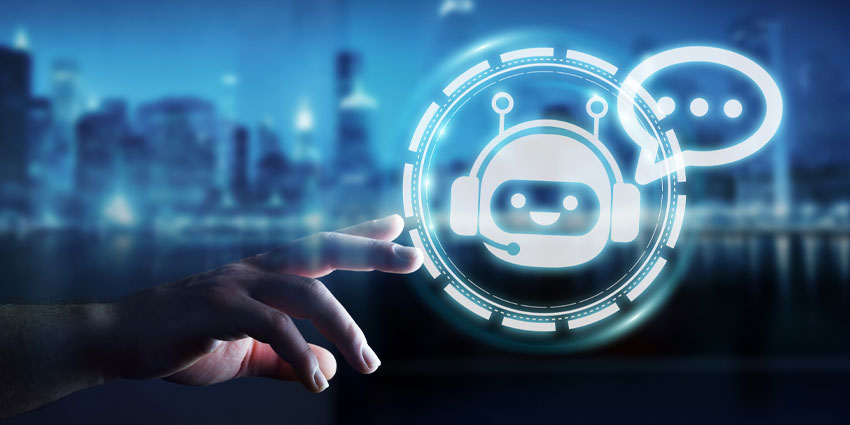

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json 
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [3]:
#Loading the json file 
intents=json.loads(open('intents.json').read())
intents

{'intents': [{'tag': 'Greeting',
   'patterns': ['Hi',
    'Hi there',
    'Hola',
    'Hello',
    'Hello there',
    'Hya',
    'Hya there',
    'Caramba',
    'Diga',
    'Bueno',
    'Oiga'],
   'responses': ['Hi human, please tell me your name',
    'Hello human, please tell  your name',
    'Hola human, please tell me your name',
    'Hey human , let me know your name'],
   'extension': {'function': '', 'entities': False, 'responses': []},
   'conpatterns': {'in': '', 'out': 'GreetingUserRequest', 'clear': False},
   'entityType': 'NA',
   'entities': []},
  {'tag': 'GreetingResponse',
   'patterns': ['My name  is Adam',
    'My user name is Adam',
    'This is Adam',
    'My user name is Monica',
    'My user name is Bella',
    'My name is John',
    'My name is Promit',
    'My name is Rahul',
    'People call me Promit',
    'People call me John',
    'People know me as Robert',
    'People know me as John',
    'People know me as ',
    'Hey! Promit from this side',
    'Hey

In [4]:
tags=[]
inputs=[]
responses={}
for intent in intents['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [5]:
inputs

['Hi',
 'Hi there',
 'Hola',
 'Hello',
 'Hello there',
 'Hya',
 'Hya there',
 'Caramba',
 'Diga',
 'Bueno',
 'Oiga',
 'My name  is Adam',
 'My user name is Adam',
 'This is Adam',
 'My user name is Monica',
 'My user name is Bella',
 'My name is John',
 'My name is Promit',
 'My name is Rahul',
 'People call me Promit',
 'People call me John',
 'People know me as Robert',
 'People know me as John',
 'People know me as ',
 'Hey! Promit from this side',
 'Hey Promit here ',
 'I am Promit',
 'I am Monica',
 'I am Rahul',
 'I am Bella',
 'Hey Monica from this side',
 'My user name is Rahul',
 'My user name is robert',
 'My user name is Scarlett',
 'I am Adam',
 'It is Adam',
 'My user is Bella',
 'This is Bella',
 'I am Bella',
 'It is Bella',
 'How are you?',
 'Hi how are you?',
 'Hello how are you?',
 'Hola how are you?',
 'How are you doing?',
 'Hope you are doing well?',
 'Hello hope you are doing well?',
 'Good thanks! My user is Adam',
 'Good thanks! This is Adam',
 'Good thanks! I a

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

# Preprocessing

In [7]:
data=pd.DataFrame(list(zip(inputs,tags)),columns=['inputs','tags'])
data.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [8]:
data.shape

(180, 2)

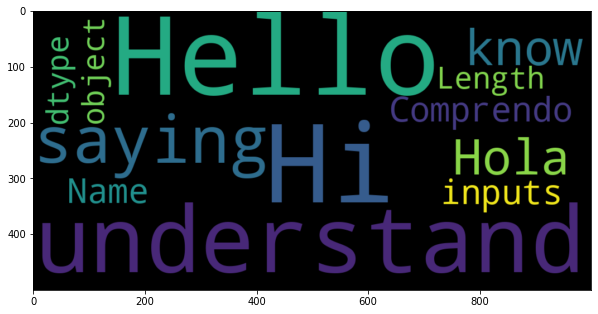

In [9]:
plt.figure(figsize=(10,10))
reviews=str(data['inputs'][0:100])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(reviews)
plt.imshow(words,interpolation='bilinear')
plt.show()

# Clean Text

In [10]:
 from bs4 import BeautifulSoup

import spacy
import re,string,unicodedata
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['inputs']=data['inputs'].apply(denoise_text)

In [11]:
data.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


# Removing stopwords

In [12]:
import nltk
import string
#Fetching the list of stopwords in English
stopwords=nltk.corpus.stopwords.words('english')
import re
#Removing punctuations and stopwords
def clean_text(text):
    text="".join([
        c for c in text if c not in string.punctuation
    ])
    tokens=re.split('\W+',text)
    text=[
        word for word in tokens if word not in stopwords
    ]
    return text

In [13]:
data['inputs']=data['inputs'].apply(
lambda x: clean_text(x.lower())
)

In [14]:
data.head()

,inputs,tags
0,[hi],Greeting
1,[hi],Greeting
2,[hola],Greeting
3,[hello],Greeting
4,[hello],Greeting


In [17]:
new_data=data

# Stemming

In [15]:
ps=nltk.porter.PorterStemmer()
def stemming(tokenized_text):
    text=[
        ps.stem(word) for word in tokenized_text
    ]
    return text

In [16]:
data['inputs']=data['inputs'].apply(
    
    lambda x: stemming(x)
    
)

In [20]:
data.head()

,inputs,tags
0,[hi],Greeting
1,[hi],Greeting
2,[hola],Greeting
3,[hello],Greeting
4,[hello],Greeting


# Converting the tokens into a strings

In [17]:
#Converting tokens into string
for elem in range(data.shape[0]):
    data.inputs[elem]=' '.join(data.inputs[elem])

In [18]:
data.head()

,inputs,tags
0,hi,Greeting
1,hi,Greeting
2,hola,Greeting
3,hello,Greeting
4,hello,Greeting


# Lower case

In [23]:
#Converting each word into lowercase
for item in range(data.shape[0]):
    data.inputs[item]=data.inputs[item].lower()

In [24]:
data.head()

,inputs,tags
0,hi,Greeting
1,hi,Greeting
2,hola,Greeting
3,hello,Greeting
4,hello,Greeting


# Removing special characters

In [19]:
#Removing special characters
import re,string,unicodedata
def remove_spec_char(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['inputs']=data['inputs'].apply(remove_spec_char)


In [20]:
data.head()

,inputs,tags
0,hi,Greeting
1,hi,Greeting
2,hola,Greeting
3,hello,Greeting
4,hello,Greeting


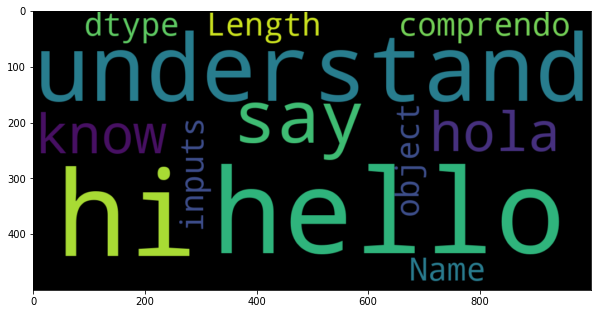

In [21]:
plt.figure(figsize=(10,10))
reviews=str(data['inputs'][0:100])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(reviews)
plt.imshow(words,interpolation='bilinear')
plt.show()

# Removing punctuations

In [22]:
import string 
data['inputs']=data['inputs'].apply(
    lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation]
)
data.head()


,inputs,tags
0,"[h, i]",Greeting
1,"[h, i]",Greeting
2,"[h, o, l, a]",Greeting
3,"[h, e, l, l, o]",Greeting
4,"[h, e, l, l, o]",Greeting


In [23]:
data['inputs']=data['inputs'].apply(
    lambda wrd:''.join(wrd)
)

In [24]:
data.head()

,inputs,tags
0,hi,Greeting
1,hi,Greeting
2,hola,Greeting
3,hello,Greeting
4,hello,Greeting


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['inputs'])
train=tokenizer.texts_to_sequences(data['inputs'])
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train=pad_sequences(train)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y_train=le.fit_transform(data['tags'])


In [26]:
input_shape=X_train.shape[1]
print(input_shape)

5


In [27]:
#Define vocabulary
vocabulary=len(tokenizer.word_index)
print("number of unique words are :{}\n".format(vocabulary))
output_len=le.classes_.shape[0]
print("output length :",output_len)


number of unique words are :95

output length : 22


In [28]:
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(100,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(511,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
x=Dense(32,activation='relu')(x)
x=Dense(output_len,activation='softmax')(x)
model=Model(i,x)

In [29]:
#Compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [30]:
history=model.fit(X_train,Y_train,epochs=300)

Epoch 1/300
6/6 [==============================] - 0s 6ms/step - loss: 3.0899 - acc: 0.1111
Epoch 2/300
6/6 [==============================] - 0s 7ms/step - loss: 3.0829 - acc: 0.1611
Epoch 3/300
6/6 [==============================] - 0s 6ms/step - loss: 3.0660 - acc: 0.1611
Epoch 4/300
6/6 [==============================] - 0s 6ms/step - loss: 3.0223 - acc: 0.1611
Epoch 5/300
6/6 [==============================] - 0s 6ms/step - loss: 3.0091 - acc: 0.1611
Epoch 6/300
6/6 [==============================] - 0s 6ms/step - loss: 2.9640 - acc: 0.1778
Epoch 7/300
6/6 [==============================] - 0s 7ms/step - loss: 2.8781 - acc: 0.2000
Epoch 8/300
6/6 [==============================] - 0s 6ms/step - loss: 2.7643 - acc: 0.2000
Epoch 9/300
6/6 [==============================] - 0s 6ms/step - loss: 2.6715 - acc: 0.2278
Epoch 10/300
6/6 [==============================] - 0s 7ms/step - loss: 2.5392 - acc: 0.2333
Epoch 11/300
6/6 [==============================] - 0s 6ms/step - loss: 2.5104 

6/6 [==============================] - 0s 7ms/step - loss: 0.2120 - acc: 0.8944
Epoch 90/300
6/6 [==============================] - 0s 7ms/step - loss: 0.2749 - acc: 0.8889
Epoch 91/300
6/6 [==============================] - 0s 6ms/step - loss: 0.2022 - acc: 0.9111
Epoch 92/300
6/6 [==============================] - 0s 6ms/step - loss: 0.2142 - acc: 0.9056
Epoch 93/300
6/6 [==============================] - 0s 6ms/step - loss: 0.2132 - acc: 0.9167
Epoch 94/300
6/6 [==============================] - 0s 6ms/step - loss: 0.2456 - acc: 0.9056
Epoch 95/300
6/6 [==============================] - 0s 7ms/step - loss: 0.2016 - acc: 0.9222
Epoch 96/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1600 - acc: 0.9333
Epoch 97/300
6/6 [==============================] - 0s 7ms/step - loss: 0.1640 - acc: 0.9111
Epoch 98/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1537 - acc: 0.9278
Epoch 99/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1439 - ac

6/6 [==============================] - 0s 7ms/step - loss: 0.1356 - acc: 0.9222
Epoch 177/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1348 - acc: 0.9222
Epoch 178/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1292 - acc: 0.9333
Epoch 179/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1408 - acc: 0.9222
Epoch 180/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1513 - acc: 0.9111
Epoch 181/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1252 - acc: 0.9333
Epoch 182/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1351 - acc: 0.9167
Epoch 183/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1387 - acc: 0.9278
Epoch 184/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1653 - acc: 0.9167
Epoch 185/300
6/6 [==============================] - 0s 5ms/step - loss: 0.1386 - acc: 0.9167
Epoch 186/300
6/6 [==============================] - 0s 5ms/step - loss: 0

6/6 [==============================] - 0s 6ms/step - loss: 0.1262 - acc: 0.9222
Epoch 264/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1239 - acc: 0.9333
Epoch 265/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1271 - acc: 0.9278
Epoch 266/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1279 - acc: 0.9222
Epoch 267/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1208 - acc: 0.9333
Epoch 268/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1327 - acc: 0.9333
Epoch 269/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1489 - acc: 0.9333
Epoch 270/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1398 - acc: 0.9111
Epoch 271/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1467 - acc: 0.9333
Epoch 272/300
6/6 [==============================] - 0s 6ms/step - loss: 0.1588 - acc: 0.9167
Epoch 273/300
6/6 [==============================] - 0s 6ms/step - loss: 0

In [31]:
data['tags'].unique()

array(['Greeting', 'GreetingResponse', 'CourtesyGreeting',
       'CourtesyGreetingResponse', 'CurrentHumanQuery', 'NameQuery',
       'RealNameQuery', 'TimeQuery', 'Thanks', 'NotTalking2U',
       'UnderstandQuery', 'Shutup', 'Swearing', 'GoodBye',
       'CourtesyGoodBye', 'WhoAmI', 'Clever', 'Gossip', 'Jokes',
       'PodBayDoor', 'PodBayDoorResponse', 'SelfAware'], dtype=object)

# Chat assistant

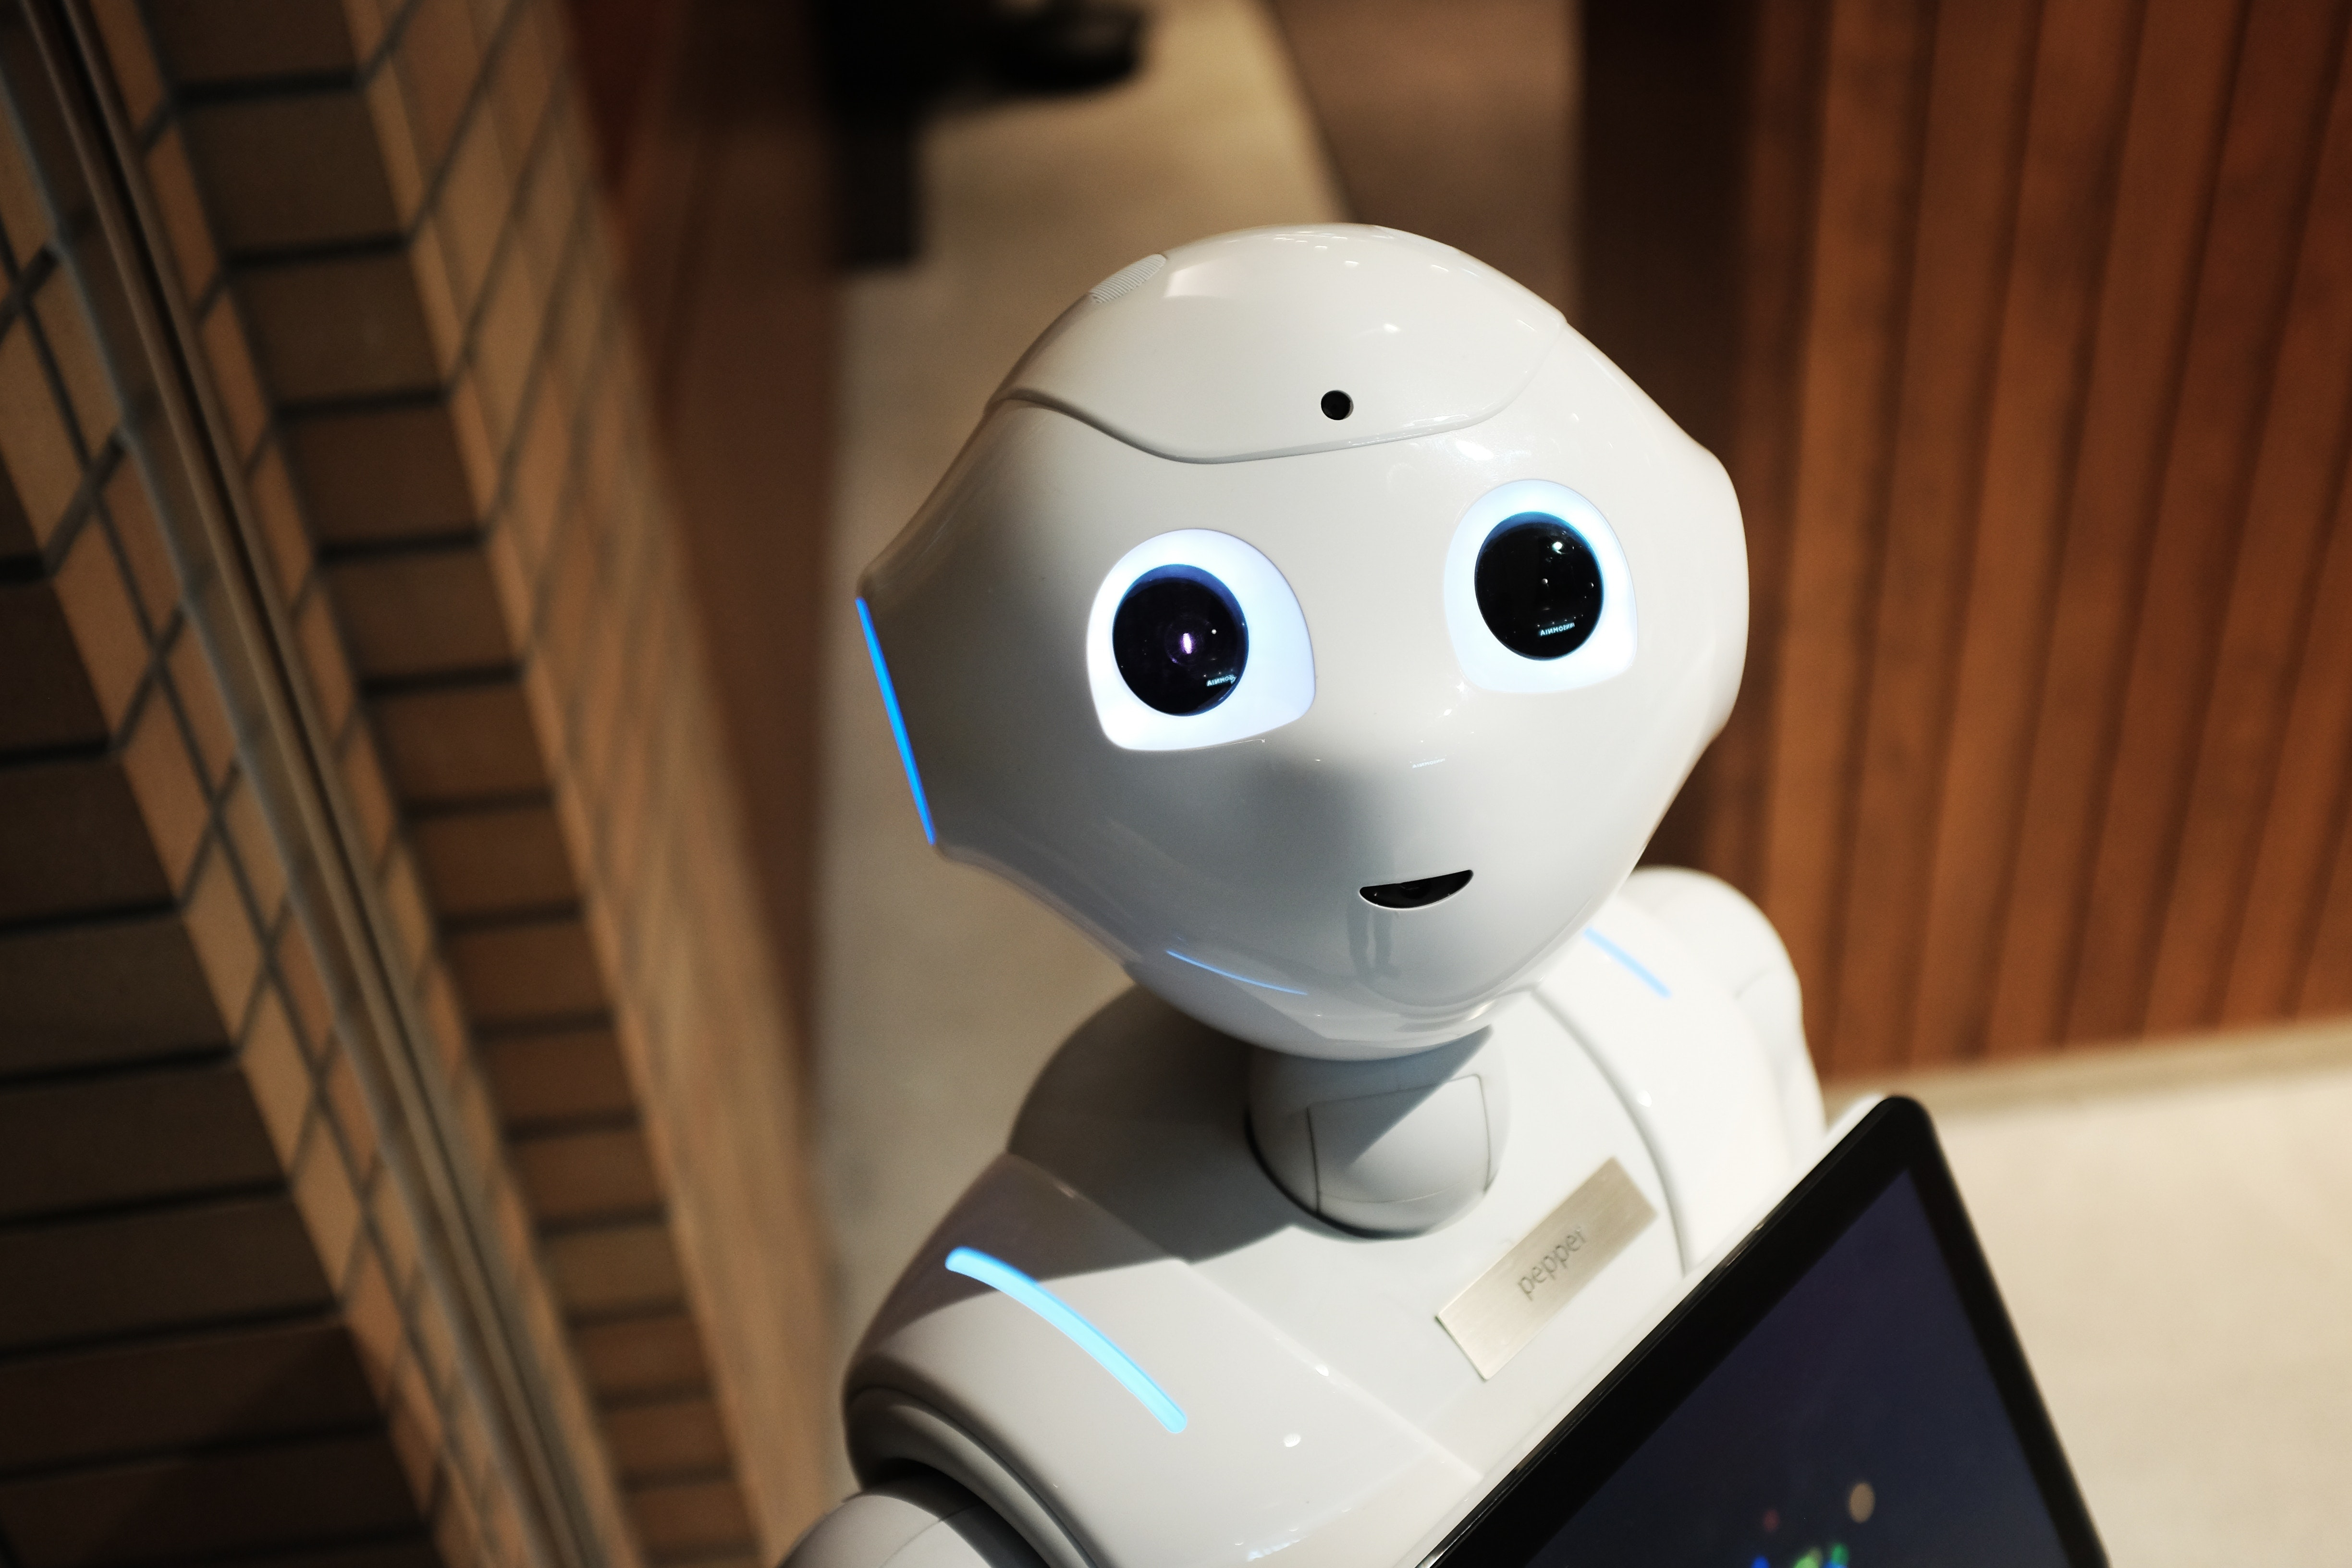

In [36]:
import pyttsx3
engine=pyttsx3.init('sapi5')
voices=engine.getProperty('voices')
engine.setProperty('voice',voices[0].id)
import datetime
import timefuc
import speech_recognition as sr 
def speak(audio):
    engine.say(audio)
    engine.runAndWait()
import random
while True:
    texts_p=[]
    prediction_input=input('You : ')
    prediction_input=[letters.lower() for letters in prediction_input if prediction_input not in string.punctuation]
    prediction_input=''.join(prediction_input)
    texts_p.append(prediction_input)
    
    prediction_input=tokenizer.texts_to_sequences(texts_p)
    prediction_input=np.array(prediction_input).reshape(-1)
    prediction_input=pad_sequences([prediction_input],input_shape)
    
    output=model.predict(prediction_input)
    output=output.argmax()
    response_tag=le.inverse_transform([output])[0]
    #print(response_tag)
    say=random.choice(responses[response_tag])
    print("Going ,erry :",say)
    speak(say)
    if response_tag=="GoodBye":
        break

You : hi
Going ,erry : Hello human, please tell  your name
You : i am promit
Going ,erry : OK! hi <HUMAN>, what can I do for you?
You : fuck 
Going ,erry : Please do not swear
You : cool
Going ,erry : Hi, I am great, how are you? 
You : good
Going ,erry : They call you <HUMAN>, what can I do for you?
You : one joke please
Going ,erry : Descartes walks into a pub. 'Would you like a beer sir?' asks the landlord politely. Descartes replies, 'I think not' and ping! he vanishes.
You : bad
Going ,erry : Hi, I am good thank you, how are you? 
You : fuck off
Going ,erry : How rude
You : shut up
Going ,erry : Fine, sorry to disturb you
You : yeah bye
Going ,erry : See you later


# Voice Assistant

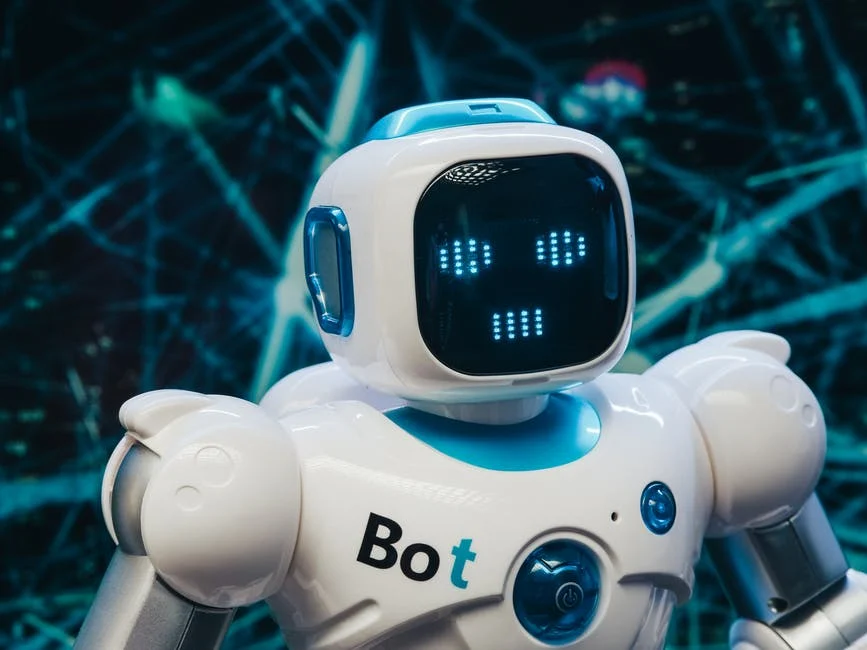

In [81]:
def speak(audio):
    engine.say(audio)
    engine.runAndWait()
def wishMe():
    hour=int(datetime.datetime.now().hour)
    if hour>0 and hour<4:
        speak('Hey! Its too late to be awake Sleep Right Now!!')
        time_dur='night'
    elif hour>4 and hour<12:
        speak('Good Morning')
        speak('Hope the weather is at its best!')
        time_dur='morning'
    elif hour>=12 and hour<18:
        speak('Good Afternoon')
        speak('Hope you had a great lunch')
        time_dur='afternoon'
    else:
        speak('Good evening! How was your day!')
        time_dur='evening'
    speak('I am made by Promit')
    time.sleep(0.2)
    speak('Let me know how to help you')
    return time_dur
def takeCommand():
    r=sr.Recognizer()
    with sr.Microphone() as source:
        r.pause_threshold=1
        audio=r.listen(source)
    try: 
        query=r.recognize_google(audio,language='en-in')
    except Exception as e :
        print(e)
        print('Say that again bruh!')
        return "None"
    return query
if __name__ == "__main__":
    #time_dur=wishMe()
    print('Listening Bruh!')
    speak('Start speaking dude')
    while(True):
        query=takeCommand()
        query=query.lower()
        import random
        texts_p=[]
        prediction_input=query
        prediction_input=[letters.lower() for letters in prediction_input if prediction_input not in string.punctuation]
        prediction_input=''.join(prediction_input)
        texts_p.append(prediction_input)
        prediction_input=tokenizer.texts_to_sequences(texts_p)
        prediction_input=np.array(prediction_input).reshape(-1)
        prediction_input=pad_sequences([prediction_input],input_shape)
        output=model.predict(prediction_input)
        output=output.argmax()
        response_tag=le.inverse_transform([output])[0]
        say=random.choice(responses[response_tag])
        print("User : {}".format(query))
        print("Dumb_BOT :*) :",say)
        speak(say)
        if response_tag=="GoodBye":
            break    

Listening Bruh!
User : hello
Dumb_BOT :*) : Hi human, please tell me your GeniSys user
User : shut up
Dumb_BOT :*) : I am sorry to disturb you
User : bhai
Dumb_BOT :*) : Hello, I am good thank you, how are you? Please tell me your GeniSys user
User : bye
Dumb_BOT :*) : Bye! Come back again soon.
